# Prepare the Catalogs

Important functions that prepare the downloaded catalogs for the cross-matching, soms and SED fitting.
Clear the catalogs for non-detections and important flags.

In [27]:
# Libraries
from astropy.table import Table
import missingno
import numpy as np

In [3]:
# Insert the path of the downloaded catalogs
emu_catalog_path = '/data/mfonseca/survey_data/EMU_data/EMU_0102-32/EMU_0102-32_1comp.fits'
des_catalog_path = '/data/mfonseca/survey_data/DES_data/DES_in_EMU_0102-32_square.fits'
viking_catalog_path = '/data/mfonseca/survey_data/VIKING_data/VIKING_in_EMU_0102-32.fits'
catwise_catalog_path = '/data/mfonseca/survey_data/CATWISE_data/CATWISE2020_in_EMU_0102-32.fits'

## Convert VEGA magnitude to AB magnitude (VIKING, CATWISE)

In [ ]:
def fix_ab_magnitude(file_path, ab_offset, mag_columns):
    '''
    Converts the vega magnitudes to ab magnitudes

    Args:
        file_path (str): Path to the FITS file.
        ab_offset (list): List of offsets for each magnitude column.
        mag_columns (list): List of magnitude column names to be corrected, same order as ab_offset.
    Returns:
        None: The function modifies the FITS file in place.
    
    '''

    catalog_table = Table.read(file_path)
    catalog_df = catalog_table.to_pandas()

    for col in mag_columns:
        # Apply the AB magnitude correction
        index = mag_columns.index(col)
        catalog_df[col] = catalog_df[col] + ab_offset[index]


    # Save the updated DataFrame back to the original FITS file
    updated_catalog_table = Table.from_pandas(catalog_df)
    updated_catalog_table.write(file_path, overwrite=True)

In [ ]:
catwise_magnitude_columns = ['w1mpro', 'w2mpro']
viking_magnitude_columns = ['zPetroMag', 'yPetroMag', 'jPetroMag', 'hPetroMag', 'ksPetroMag']

# https://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html
catwise_ab_offset = [2.699, 3.339]
# http://casu.ast.cam.ac.uk/surveys-projects/vista/technical/filter-set
viking_ab_offset = [0.502, 0.600, 0.916, 1.366, 1.827]

In [ ]:
fix_ab_magnitude(catwise_catalog_path, catwise_ab_offset, catwise_magnitude_columns)
fix_ab_magnitude(viking_catalog_path, viking_ab_offset, viking_magnitude_columns)

## Calculate Colors (VIKING, CATWISE)

In [ ]:
# For the VIKING catalog
catalog_table = Table.read(viking_catalog_path)
viking_catalog_df = catalog_table.to_pandas()

viking_catalog_df['z_y'] = viking_catalog_df['zPetroMag'] - viking_catalog_df['yPetroMag']
viking_catalog_df['y_j'] = viking_catalog_df['yPetroMag'] - viking_catalog_df['jPetroMag']
viking_catalog_df['j_h'] = viking_catalog_df['jPetroMag'] - viking_catalog_df['hPetroMag']
viking_catalog_df['h_ks'] = viking_catalog_df['hPetroMag'] - viking_catalog_df['ksPetroMag']

updated_catalog_table = Table.from_pandas(viking_catalog_df)
updated_catalog_table.write(viking_catalog_path, overwrite=True)

In [ ]:
# For the CATWISE catalog
catwise_catalog_table = Table.read(catwise_catalog_path)
catwise_catalog_df = catwise_catalog_table.to_pandas()

catwise_catalog_df['w1_w2'] = catwise_catalog_df['w1mpro'] - catwise_catalog_df['w2mpro']

updated_catalog_table = Table.from_pandas(catwise_catalog_df)
updated_catalog_table.write(catwise_catalog_path, overwrite=True)

# Filter for non-detections or other important flags

## DES catalog

## VIKING catalog

In [ ]:
catalog_table = Table.read(viking_catalog_path)
viking_catalog_df = catalog_table.to_pandas()

In [37]:
print(f'total number of objects in VIKING catalog: {len(viking_catalog_df)}')

# Recomendation from https://www.eso.org/rm/api/v1/public/releaseDescriptions/135, page 7
pixel_match = (viking_catalog_df['zppErrBits']<255) & (viking_catalog_df['yppErrBits']<255) & (viking_catalog_df['ksErrBits']<255) & (viking_catalog_df['jErrBits']<255) & (viking_catalog_df['hErrBits']<255)


filtered_viking_catalog_df = viking_catalog_df[pixel_match]

print(f'total number of objects in VIKING catalog after pixel filtering: {len(filtered_viking_catalog_df)}')

filtered_viking_catalog_path = '/data/mfonseca/survey_data/VIKING_data/VIKING_in_EMU_0102-32_pixelmatch.fits'

updated_catalog_table = Table.from_pandas(filtered_viking_catalog_df)
updated_catalog_table.write(filtered_viking_catalog_path, overwrite=True)

total number of objects in VIKING catalog: 2991542
total number of objects in VIKING catalog after pixel filtering: 2358794


In [39]:
print(f'the nan value is: {viking_catalog_df['zPetroMag'].tail(len(viking_catalog_df)).unique().min()}')

z_filter = viking_catalog_df[~np.isclose(viking_catalog_df['zPetroMag'], -9.99999489e+08)]
y_filter = viking_catalog_df[~np.isclose(viking_catalog_df['yPetroMag'], -9.99999489e+08)]
j_filter = viking_catalog_df[~np.isclose(viking_catalog_df['jPetroMag'], -9.99999489e+08)]
h_filter = viking_catalog_df[~np.isclose(viking_catalog_df['hPetroMag'], -9.99999489e+08)]
ks_filter = viking_catalog_df[~np.isclose(viking_catalog_df['ksPetroMag'], -9.99999489e+08)]


print(f'{len(z_filter)} ({(len(z_filter)/len(viking_catalog_df))*100:.2f}%) objects have a nan value in the z filter')
print(f'{len(y_filter)} ({(len(y_filter)/len(viking_catalog_df))*100:.2f}%) objects have a nan value in the y filter')
print(f'{len(j_filter)} ({(len(j_filter)/len(viking_catalog_df))*100:.2f}%) objects have a nan value in the j filter')
print(f'{len(h_filter)} ({(len(h_filter)/len(viking_catalog_df))*100:.2f}%) objects have a nan value in the h filter')
print(f'{len(ks_filter)} ({(len(ks_filter)/len(viking_catalog_df))*100:.2f}%) objects have a nan value in the ks filter')

the nan value is: -999999489.498
2308480 (77.17%) objects have a nan value in the z filter
1591287 (53.19%) objects have a nan value in the y filter
1616915 (54.05%) objects have a nan value in the j filter
1213849 (40.58%) objects have a nan value in the h filter
1205391 (40.29%) objects have a nan value in the ks filter


## CATWISE catalog

In [41]:
catalog_table = Table.read(catwise_catalog_path)
catwise_catalog_df = catalog_table.to_pandas()

the nan value is: 7.239999771118164


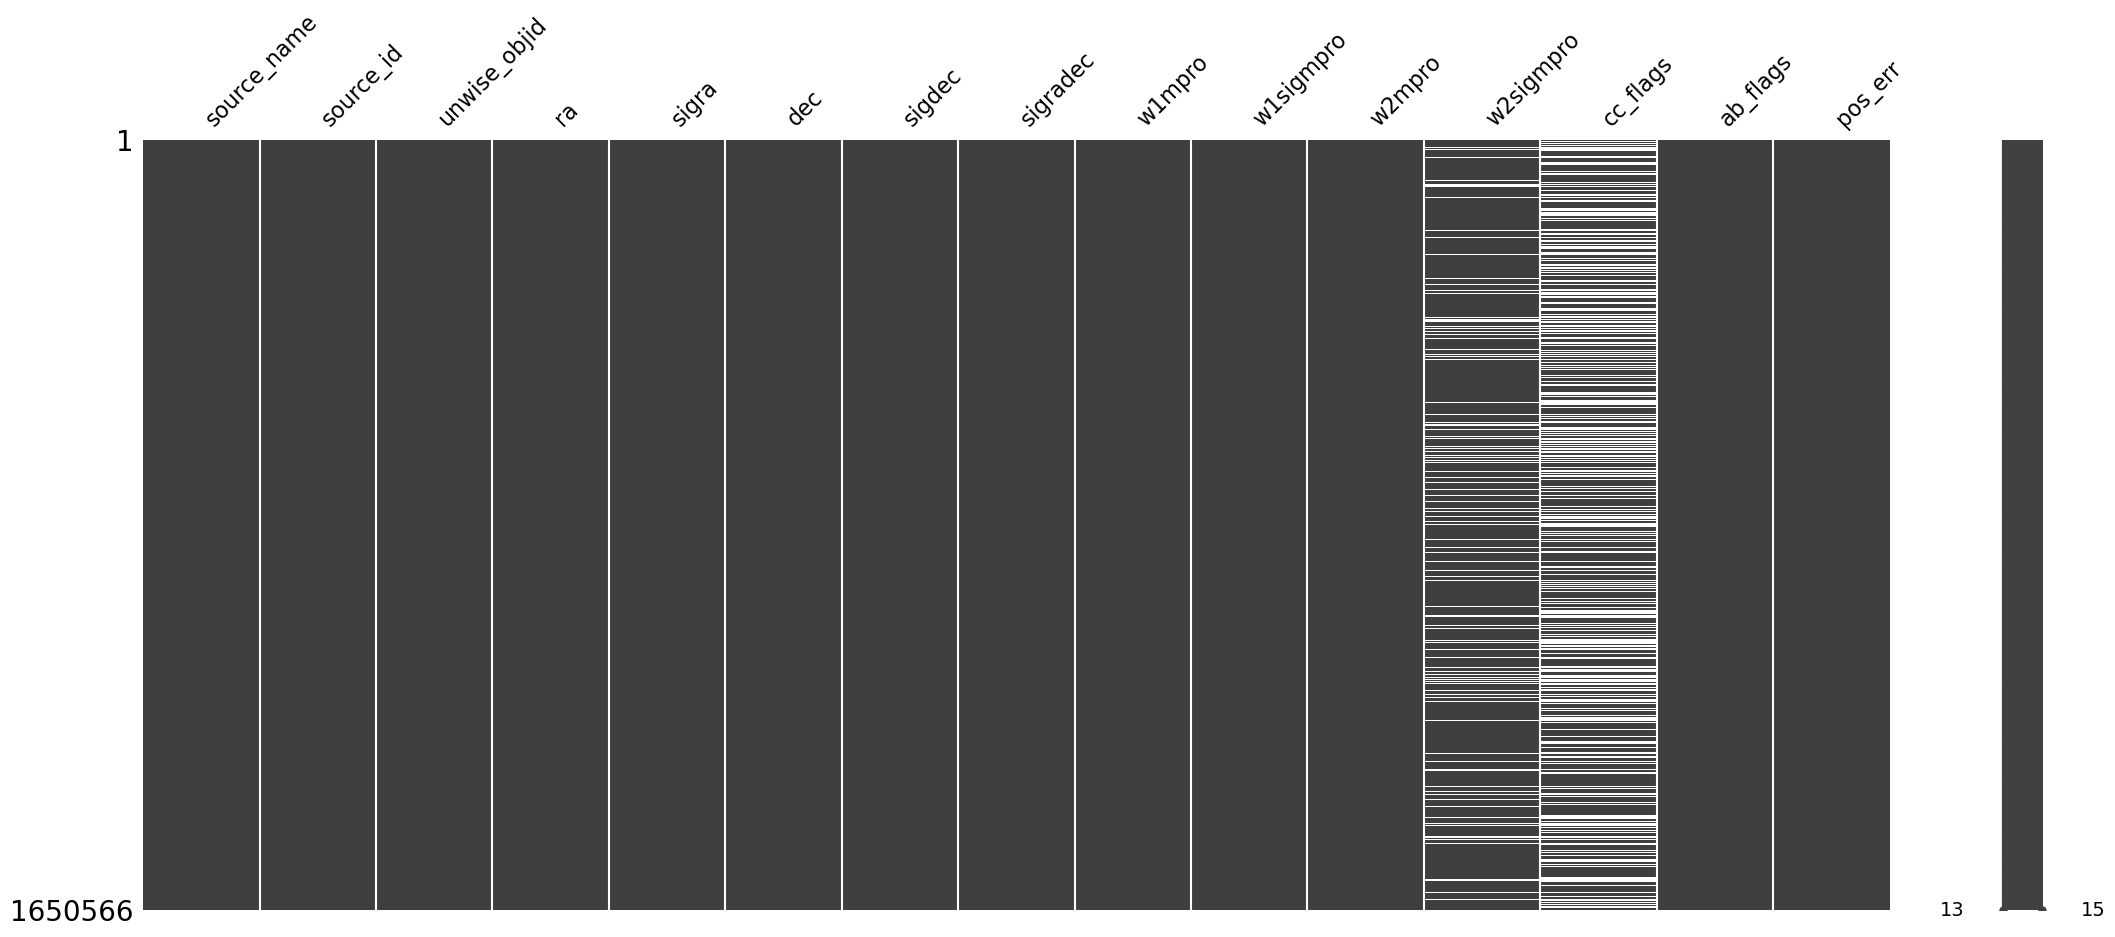

In [45]:
# This shows us that catwise doesn't have nan values

missingno.matrix(catwise_catalog_df)

print(f'the nan value is: {catwise_catalog_df['w1mpro'].tail(len(catwise_catalog_df)).unique().min()}')